# DenseNet training
This notebook trains an DenseNet model for multi-class classification on the ERCP dataset.

In [1]:
from livelossplot import PlotLosses 
from livelossplot.outputs import MatplotlibPlot

%matplotlib inline
import matplotlib.pyplot as plt

from monai.transforms import (Activations, AsDiscrete, LoadImage, EnsureChannelFirst, Resize,
                                RandZoom, RandAdjustContrast, RandGaussianNoise, RandRotate,
                                ToTensor, Compose, NormalizeIntensity, Lambda)
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.utils import set_determinism
from monai.config import print_config
from monai.networks.nets import DenseNet121

import numpy as np

import os

from PIL import Image

import random

import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import time

import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torchmetrics.classification import MulticlassF1Score


np.random.seed(0)
set_determinism(seed=0)
print_config()

MONAI version: 1.5.1
Numpy version: 2.2.6
Pytorch version: 2.9.1+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9c6d819f97e37f36c72f3bdfad676b455bd2fa0d
MONAI __file__: /mounts/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.3
Pillow version: 12.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.24.1+cu128
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.3.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.57.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.


In [2]:
model_name = './models/densenet.pth'

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


## Dataset
Load dataset paths and compute class counts. This section populates `data` with `train`, `val`, and `test` image file lists and their labels.

In [4]:
base_dir = '/mounts/monica/ERCP_image_classification/dataset'
phases = ['train', 'val', 'test']

data = {phase: {'images': [], 'labels': []} for phase in phases}
class_names = sorted([x for x in os.listdir(os.path.join(base_dir, 'train')) if os.path.isdir(os.path.join(base_dir, 'train', x))])
#class_names = sorted([x for x in os.listdir(os.path.join(base_dir, 'train')) if os.path.isdir(os.path.join(base_dir, 'train', x))])
num_class = len(class_names)

def load_images_labels(phase):
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, phase, class_name)
        valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
        image_files = [
                            os.path.join(class_dir, x)
                            for x in os.listdir(class_dir)
                            if x.lower().endswith(valid_exts)
                        ]

        data[phase]['images'].extend(image_files)
        data[phase]['labels'].extend([i] * len(image_files))

for phase in phases:
    load_images_labels(phase)

for phase in phases:
    print(f"{phase.capitalize()} count =", len(data[phase]['images']))
    

Train count = 1067
Val count = 234
Test count = 267


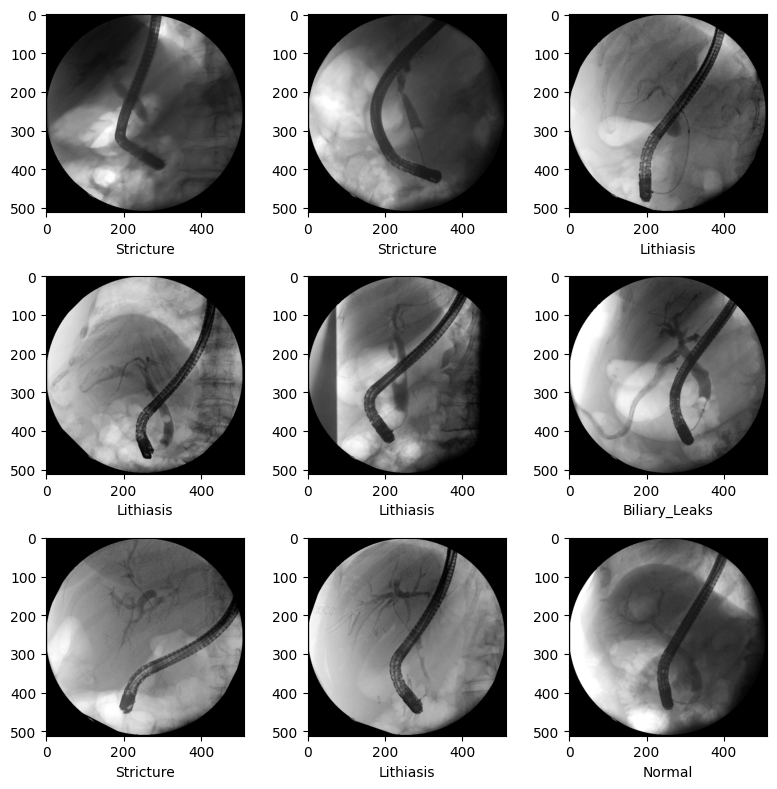

In [5]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(len(data['train']['images']), size=9)):
    im = Image.open(data['train']['images'][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[data['train']['labels'][k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()


----- TRAIN CASES -----
cases: 1067
['Biliary_Leaks', 'Lithiasis', 'Normal', 'Stricture']
['0', '1', '2', '3']
[110 505 197 255]
1067


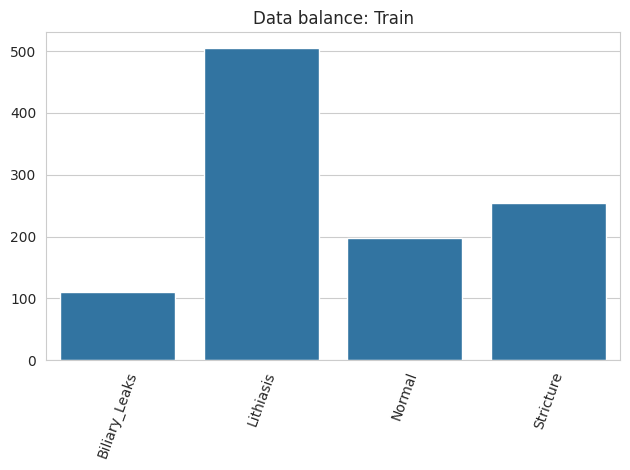

----- VALIDATION CASES -----
cases: 234
['Biliary_Leaks', 'Lithiasis', 'Normal', 'Stricture']
['0', '1', '2', '3']
[24 98 59 53]
234


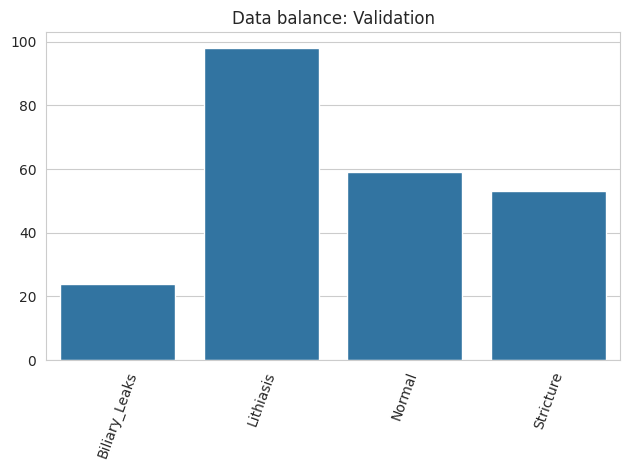

----- TEST CASES -----
cases: 267
['Biliary_Leaks', 'Lithiasis', 'Normal', 'Stricture']
['0', '1', '2', '3']
[ 17 123  43  84]
267


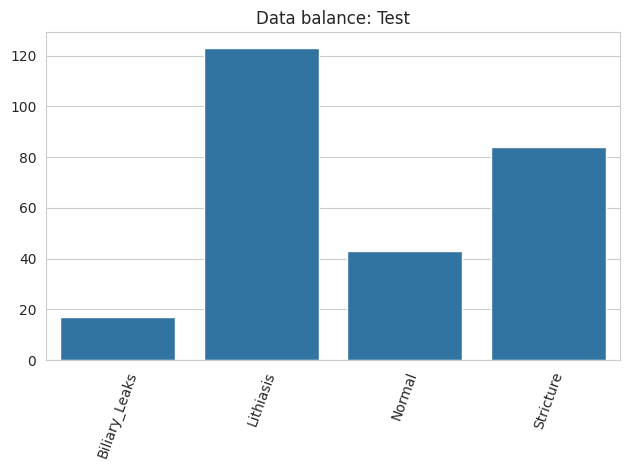

In [6]:
def visualize_holdout_balance(labels, class_names, header):
    sns.set_style('whitegrid')
    print("cases:", len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[class_names[n]  for n in x]
    print(x_ext)
    print([str(n) for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x_ext, y=y)
    grafico.set_title(f'Data balance: {header}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

print("----- TRAIN CASES -----")
visualize_holdout_balance(data['train']['labels'], class_names, 'Train')
print("----- VALIDATION CASES -----")
visualize_holdout_balance(data['val']['labels'], class_names, 'Validation')
print("----- TEST CASES -----")
visualize_holdout_balance(data['test']['labels'], class_names, 'Test')


## Transforms
Define data augmentation and preprocessing for training and validation. Images are resized to 512×512.

In [7]:
class EnsureSingleChannel:
    def __call__(self, img):
        if img.shape[0] == 3:
            img = img.mean(dim=0, keepdim=True)
        return img

def repeat_if_needed(img):
    if img.shape[0] == 1:
        return img.repeat(3, 1, 1)
    return img
    
train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((512, 512)),
    RandRotate(range_x=15, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    RandAdjustContrast(prob=0.5),
    RandGaussianNoise(prob=0.3, mean=0.0, std=0.01),
    NormalizeIntensity(),
    Lambda(repeat_if_needed),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((512, 512)),
    NormalizeIntensity(),
    Lambda(repeat_if_needed),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)

## Dataset & DataLoaders
Wrap file paths into a Dataset and create DataLoaders for training, validation and testing.

In [8]:
class MedNISTDataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image = self.image_files[index]
        return self.transforms(image), self.labels[index]

train_ds = MedNISTDataset(data['train']['images'], data['train']['labels'], train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)

val_ds = MedNISTDataset(data['val']['images'], data['val']['labels'], val_transforms)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=0)

test_ds = MedNISTDataset(data['test']['images'], data['test']['labels'], val_transforms)
test_loader = DataLoader(test_ds, batch_size=4, num_workers=0)

## Model
Instantiate an DenseNet backbone (pretrained) and adapt the classifier head to the number of classes.

In [9]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,             # 2D images
    in_channels=3,   
    out_channels=num_class,  
    pretrained=True 
).to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /mounts/monica/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:02<00:00, 11.6MB/s]


## Training
The `train_model` function runs the training loop with optional early stopping, learning rate scheduling and logging of metrics (F1, AUC). Parameters and training logic are unchanged.

In [10]:

def train_model(train_dl, val_dl, model, loss_function, optimizer, epochs, name):
    early_stopping_patience = 10
    epochs_without_improvement = 0
    liveloss = PlotLosses(outputs=[MatplotlibPlot(figpath=f"{name}.png")])
    best_metric = -1
    best_metric_epoch = -1
    metric_values = list()

    # F1 metric
    f1_metric = MulticlassF1Score(num_classes=num_class, average='macro').to(device)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs) 

    for epoch in range(epochs):
        logs = {}
        model.train()
        epoch_loss = 0
        running_loss = 0.0
        running_corrects = 0.0
        y_pred_train = torch.tensor([], dtype=torch.float32, device=device)
        y_train = torch.tensor([], dtype=torch.long, device=device)

        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #outputs = torch.softmax(outputs, dim=1)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            y_pred_train = torch.cat([y_pred_train, outputs], dim=0)
            y_train = torch.cat([y_train, labels], dim=0)

        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)

        # Compute F1-score on training set
        pred_train_labels = y_pred_train.argmax(dim=1)
        f1_train_value = f1_metric(pred_train_labels, y_train)

        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        logs['F1'] = f1_train_value.item()  # Train F1

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)

        with torch.no_grad():
            for val_images, val_labels in val_dl:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                outputs = model(val_images)
                #outputs = torch.softmax(outputs, dim=1)
                loss = loss_function(outputs, val_labels)
                running_loss += loss.detach() * val_images.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == val_labels.data)
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            epoch_loss = running_loss / len(val_dl.dataset)
            epoch_acc = running_corrects.float() / len(val_dl.dataset)
            logs['val_loss'] = epoch_loss.item()
            logs['val_accuracy'] = epoch_acc.item()

            # Compute F1-score on validation set
            pred_labels = y_pred.argmax(dim=1)
            f1_score_value = f1_metric(pred_labels, y)
            logs['val_F1'] = f1_score_value.item()

            y_onehot = [to_onehot(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [act(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)

            if f1_score_value > best_metric:
                best_metric = f1_score_value
                best_metric_epoch = epoch + 1
                best_train_f1 = f1_train_value.item()   
                torch.save(model.state_dict(), name)
                print('saved new best metric model')
                epochs_without_improvement = 0  # reset counter
            else:
                epochs_without_improvement += 1
            
            if epochs_without_improvement >= early_stopping_patience:
                print(
                    f"Early stopping at epoch {epoch + 1} \n"
                    f" Best Val F1: {best_metric:.4f} \n"
                    f" Best Train F1: {best_train_f1:.4f} \n"
                    f" current Val F1: {f1_score_value:.4f} \n"
                    f" current Train F1: {f1_train_value:.4f} \n"
                    f" Best epoch: {best_metric_epoch} \n"
                )
                break
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current F1 (train): {f1_train_value:.4f}"
                f" current F1 (val): {f1_score_value:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
        
        logs['val_AUC'] = result
        liveloss.update(logs)
        liveloss.send()

        scheduler.step() 

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


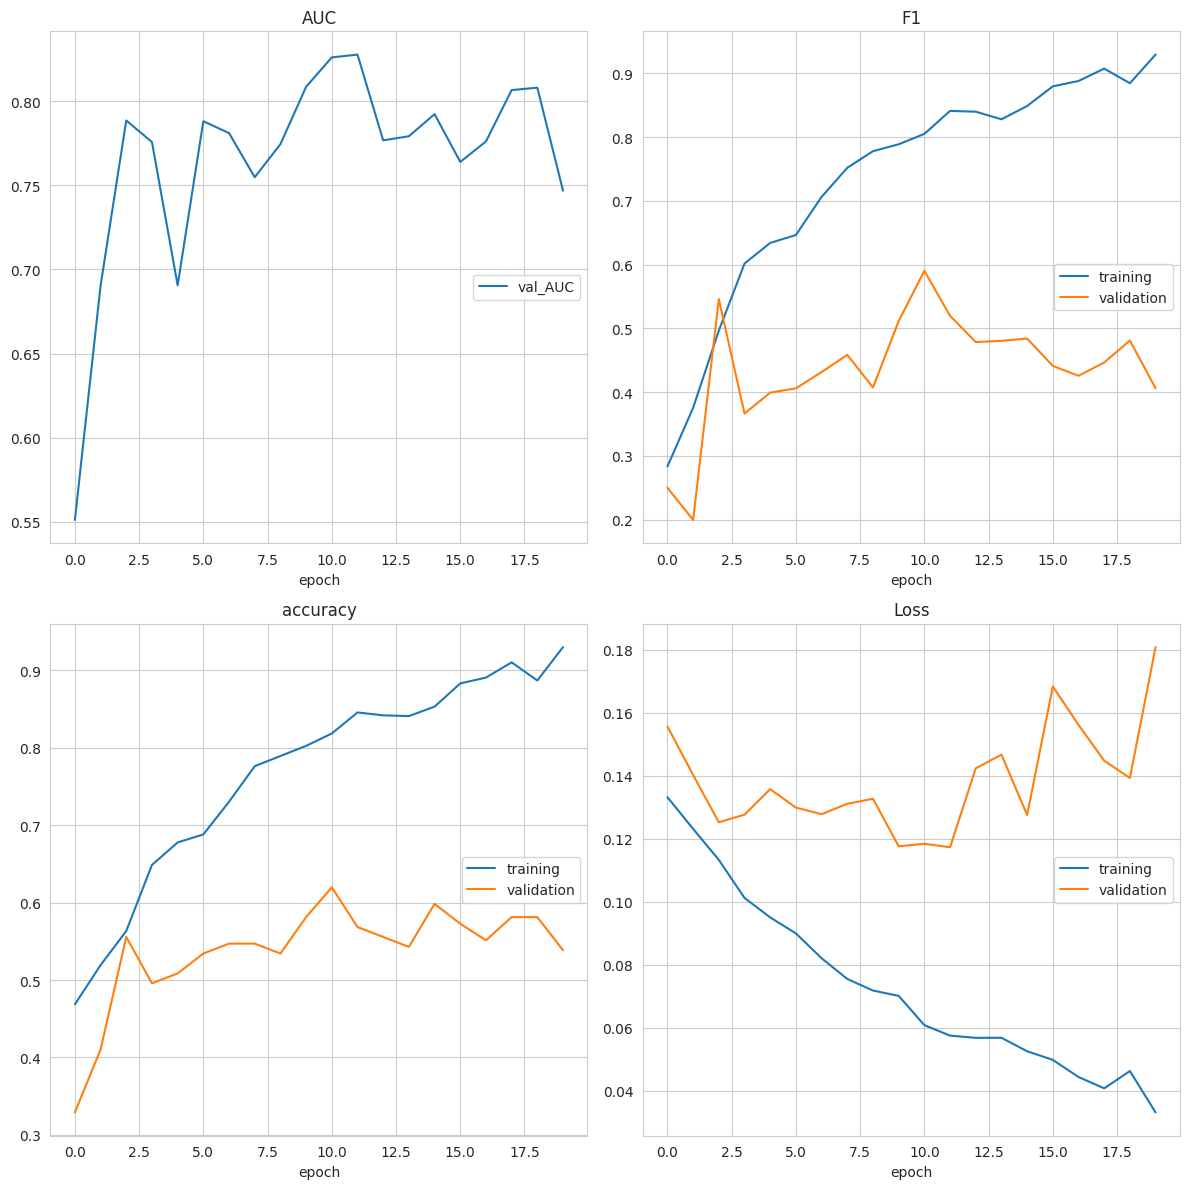

Early stopping at epoch 21 
 Best Val F1: 0.5901 
 Best Train F1: 0.8049 
 current Val F1: 0.4566 
 current Train F1: 0.9103 
 Best epoch: 11 

train completed, best_metric: 0.5901 at epoch: 11
Time elapsed: 819.484956471948 seconds


In [11]:
EPOCHS = 60
LEARNING_RATE = 1e-4

from monai.losses import FocalLoss
loss_function = FocalLoss(to_onehot_y=True)

optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)

val_interval = 1
auc_metric = ROCAUCMetric()

device = torch.device("cuda")
starttime = time.perf_counter()
train_model(train_loader, val_loader, model, loss_function, optimizer, EPOCHS, model_name)
endtime = time.perf_counter()
print(f"Time elapsed: {endtime - starttime} seconds")

## Evaluation
Evaluate the model on the test set, compute F1/accuracy and plot a confusion matrix. The following cells perform inference and generate the final metrics and plots.

F1 Score: 0.6207
true: [0] pred: [0]
true: [0] pred: [1]
true: [0] pred: [2]
true: [0] pred: [0]
true: [0] pred: [0]
true: [0] pred: [2]
true: [0] pred: [0]
true: [0] pred: [2]
true: [0] pred: [0]
true: [0] pred: [0]
true: [0] pred: [2]
Accuracy: 0.659

correct: 6 incorrect: 5
Accuracy: 0.659

correct: 6 incorrect: 5
F1 Score: 0.6207
               precision    recall  f1-score   support

Biliary_Leaks     0.6364    0.4118    0.5000        17
    Lithiasis     0.6718    0.7154    0.6929       123
       Normal     0.5352    0.8837    0.6667        43
    Stricture     0.7963    0.5119    0.6232        84

     accuracy                         0.6592       267
    macro avg     0.6599    0.6307    0.6207       267
 weighted avg     0.6867    0.6592    0.6545       267

[[ 7  1  9  0]
 [ 3 88 21 11]
 [ 0  5 38  0]
 [ 1 37  3 43]]


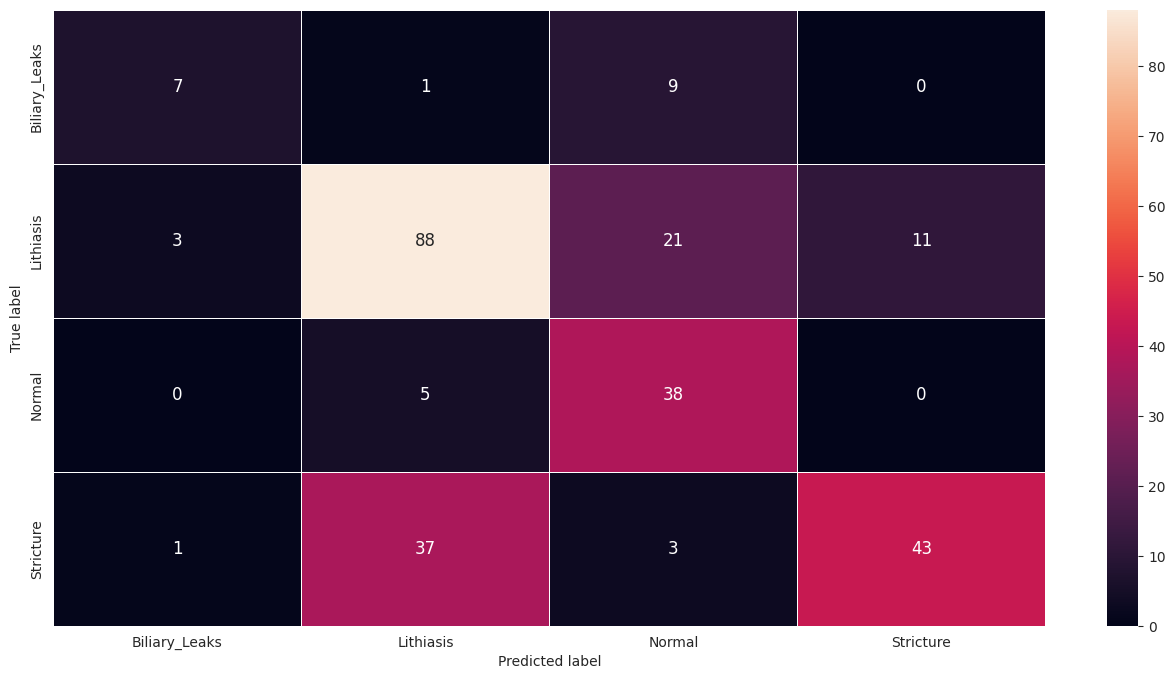

In [12]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        # evaluate the model on the test set
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    
    # Compute F1-score
    f1 = f1_score(actual_values, predictions, average='macro')  # Can be 'micro', 'macro' or 'weighted'
    print(f"F1 Score: {f1:0.4f}")
    
    return actual_values, predictions

def display_predictions(actual_values, predictions):
    right = 0
    wrong = 0
    primeiros = 0
    i = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'true: {r} pred: {p}')
            primeiros += 1
        if r == p:
            right += 1
        else:
            wrong += 1
        i += 1
        if i > 10:
            break

    # Compute accuracy
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_loader.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'correct: {right} incorrect: {wrong}')
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'correct: {right} incorrect: {wrong}')

    # Compute F1-score
    f1 = f1_score(actual_values, predictions, average='macro')
    print(f"F1 Score: {f1:0.4f}")

def display_confusion_matrix(cm, list_classes, filename):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f"{filename}_cm.png", dpi=300)
    plt.show()

# Load trained model
model.load_state_dict(torch.load('./' + model_name))
model.eval()

# Evaluate the model
actual_values, predictions = evaluate_model(test_loader, model)

# Display the predictions
display_predictions(actual_values, predictions)

# Classification report
print(classification_report(actual_values, predictions, target_names=class_names, digits=4, zero_division=0))

# Confusion Matrix
cr = classification_report(actual_values, predictions, target_names=class_names, output_dict=True)
list_classes = [cls for cls in cr.keys() if cls in class_names]

cm = confusion_matrix(actual_values, predictions)

print(cm)
display_confusion_matrix(cm, list_classes, model_name)